### Урок 5. Кейс 1. Аномалии и артефакты

1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями
2. Добавьте первые разности по стоимости доллара и евро к рублю
3. сделайте ее перрасчет (ресемплинг) в представление по неделям. 
4. Постройте модель предсказания 1-й точки от текущей (h=1).

5. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

1. Читаем базу my_BRENT2019.csv. Переходим к представлению ряда первыми разностями

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import itertools
from sklearn.ensemble import GradientBoostingRegressor 

import warnings
warnings.filterwarnings("ignore")

In [2]:
Path_Brent = 'my_BRENT2019.csv'
data = pd.read_csv(Path_Brent, sep = ',', index_col=[0], parse_dates=[0])

In [3]:
data['first_diff'] = 0
data['first_diff'][1:] = data['Значение'].diff()[1:]
data['first_diff']

Дата
2010-09-01    0.00
2010-09-02    0.52
2010-09-03   -0.32
2010-09-04    0.05
2010-09-05    0.01
              ... 
2019-08-27    1.33
2019-08-28    0.25
2019-08-29    0.53
2019-08-30   -1.18
2019-09-01   -0.35
Name: first_diff, Length: 2667, dtype: float64

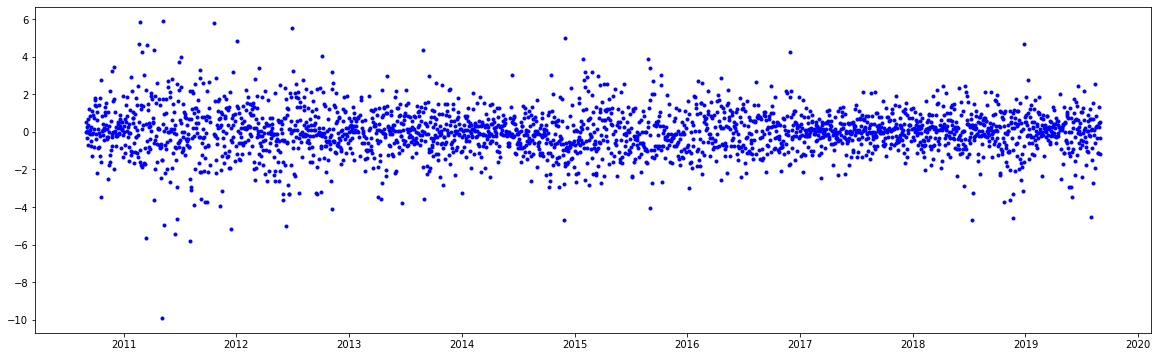

In [4]:
plt.figure(figsize=(20,6))
plt.plot(data.index, data.first_diff, '.b');

--------------------------------------------------------------------------------------------------------------------

2. Добавим первые разности по стоимости доллара и евро к рублю

In [5]:
rub_doll = pd.read_excel('RC_F01_09_2010_T01_09_2019.xlsx')
rub_doll.index = pd.to_datetime(rub_doll['data'].values).date

rub_e = pd.read_excel('R_E01_09_2010_T01_09_2019.xlsx')
rub_e.index = pd.to_datetime(rub_e['data'].values).date

Первые разности

In [6]:
rub_doll['doll_diff'] = 0.
rub_doll['doll_diff'][1:] = rub_doll['curs'].diff()[1:]
rub_e['euro_diff'] = 0.
rub_e['euro_diff'][1:] = rub_e['curs'].diff()[1:]

In [7]:
rub_doll.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2228 entries, 2010-09-01 to 2019-08-31
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   nominal    2228 non-null   int64         
 1   data       2228 non-null   datetime64[ns]
 2   curs       2228 non-null   float64       
 3   cdx        2228 non-null   object        
 4   doll_diff  2228 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 104.4+ KB


In [8]:
rub_e.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2228 entries, 2010-09-01 to 2019-08-31
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   nominal    2228 non-null   int64         
 1   data       2228 non-null   datetime64[ns]
 2   curs       2228 non-null   float64       
 3   cdx        2228 non-null   object        
 4   euro_diff  2228 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 104.4+ KB


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2667 entries, 2010-09-01 to 2019-09-01
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Значение         2667 non-null   float64
 1   year             2667 non-null   int64  
 2   month            2667 non-null   int64  
 3   dayofmonth       2667 non-null   int64  
 4   quarter          2667 non-null   int64  
 5   dayofyear        2667 non-null   int64  
 6   weekofyear       2667 non-null   int64  
 7   dayofweek        2667 non-null   int64  
 8   is_holiday       2667 non-null   int64  
 9   is_prev_holiday  2667 non-null   int64  
 10  is_next_holiday  2667 non-null   int64  
 11  first_diff       2667 non-null   float64
dtypes: float64(2), int64(10)
memory usage: 270.9 KB


In [10]:
data['doll_diff'] = 0.
data['doll_diff'][:2227] = rub_doll['doll_diff'][1:]

data['euro_diff'] = 0.
data['euro_diff'][:2227] = rub_e['euro_diff'][1:]

In [11]:
lst_cols = data.columns
right_cols = [0, 11, 12, 13]
right_cols = lst_cols[right_cols]
data = data[:2227][right_cols]

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2227 entries, 2010-09-01 to 2018-04-02
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Значение    2227 non-null   float64
 1   first_diff  2227 non-null   float64
 2   doll_diff   2227 non-null   float64
 3   euro_diff   2227 non-null   float64
dtypes: float64(4)
memory usage: 87.0 KB


--------------------------------------------------------------------------------------------------------------------

3. Сделаем ее перрасчет (ресемплинг) в представление по неделям. 

In [13]:
data_w = data.resample('W').mean()

In [14]:
data_w.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 2010-09-05 to 2018-04-08
Freq: W-SUN
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Значение    396 non-null    float64
 1   first_diff  396 non-null    float64
 2   doll_diff   396 non-null    float64
 3   euro_diff   396 non-null    float64
dtypes: float64(4)
memory usage: 15.5 KB


In [15]:
data_w.columns = ['value', 'first_diff', 'doll_diff', 'euro_diff']

Пропуски в данных

In [16]:
data_w[57:60]

,value,first_diff,doll_diff,euro_diff
Дата,,,,
2011-10-09,103.476667,0.455000,-0.108600,-0.250433
2011-10-16,NaN,NaN,NaN,NaN
2011-10-23,109.756667,1.806667,-0.085533,0.139300


In [17]:
data_w.iloc[58] = (data_w.iloc[57] + data_w.iloc[59])/2

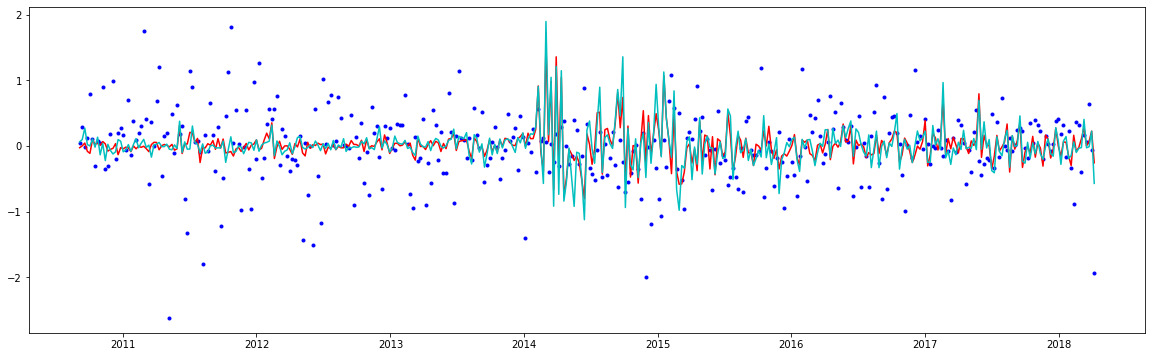

In [18]:
plt.figure(figsize=(20, 6))
plt.plot(data_w.index, data_w.first_diff, '.b');
plt.plot(data_w.index, data_w.doll_diff, '-r');
plt.plot(data_w.index, data_w.euro_diff, '-c');

--------------------------------------------------------------------------------------------------------------------

4. Построим модель предсказания 1-й точки от текущей (h=1).

In [19]:
test_ADF = sm.tsa.stattools.adfuller(data_w['first_diff'].values, regression='ctt')
print(f'adf = {test_ADF[0]}\n' 
      f'критическое значение при 10% ошибке = {test_ADF[4]["10%"]}')

adf = -19.2479399354442
критическое значение при 10% ошибке = -3.5625361905833923


То есть ряд 'first_diff' стационарный.

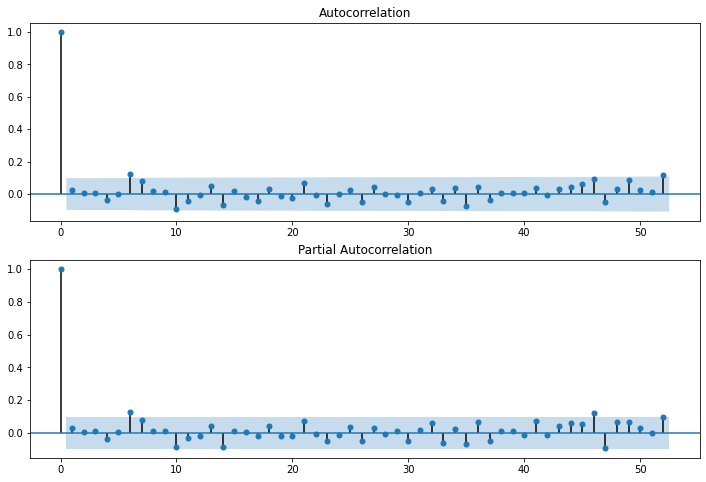

In [20]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data_w['first_diff'].values, lags=52, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data_w['first_diff'].values, lags=52, ax=ax2)

__Предсказание с помощью ARIMA__

На графиках ACF и PACF выделяются значения p и q, равные 0 и 6.

In [21]:
p = q = [0, 6]
d = [0, 1, 2]
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 0) for x in list(itertools.product(p, d, q))]

In [22]:
min_aic = np.inf
best_param = (0, 0, 0)
best_param_seasonal = (0, 0, 0, 6)

params_result = pd.DataFrame(columns=['param', 'param_seasonal', 'aic'])
i = 0

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model_1 = sm.tsa.statespace.SARIMAX(data_w['first_diff'].values[:-1],
                                    order=param,
                                    seasonal_order=param_seasonal,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = model_1.fit()
            params_result.loc[i, 'param'] = param
            params_result.loc[i, 'param_seasonal'] = param_seasonal
            params_result.loc[i, 'aic'] = results.aic
            i +=1
            if results.aic < min_aic:
                min_aic = results.aic
                best_param = param
                best_param_seasonal = param_seasonal            
        except:
            continue
            
print(f'Best SARIMA parameters: {best_param}x{best_param_seasonal} with min AIC = {min_aic}')

Best SARIMA parameters: (0, 0, 6)x(0, 0, 0, 0) with min AIC = 613.4980095587039


In [23]:
h = 1
model_ARIMA = sm.tsa.statespace.SARIMAX(data_w['first_diff'].values[:-h],
                                order=best_param,
                                seasonal_order=best_param_seasonal,
                                enforce_stationarity= False,
                                enforce_invertibility=False)
results_ARIMA = model_ARIMA.fit()

In [24]:
print(results_ARIMA.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0034      0.054      0.064      0.949      -0.102       0.108
ma.L2          0.0243      0.051      0.474      0.636      -0.076       0.125
ma.L3          0.0126      0.052      0.245      0.807      -0.088       0.114
ma.L4         -0.0215      0.045     -0.483      0.629      -0.109       0.066
ma.L5         -0.0092      0.050     -0.182      0.856      -0.108       0.090
ma.L6          0.1373      0.049      2.813      0.005       0.042       0.233
sigma2         0.2733      0.014     19.355      0.000       0.246       0.301


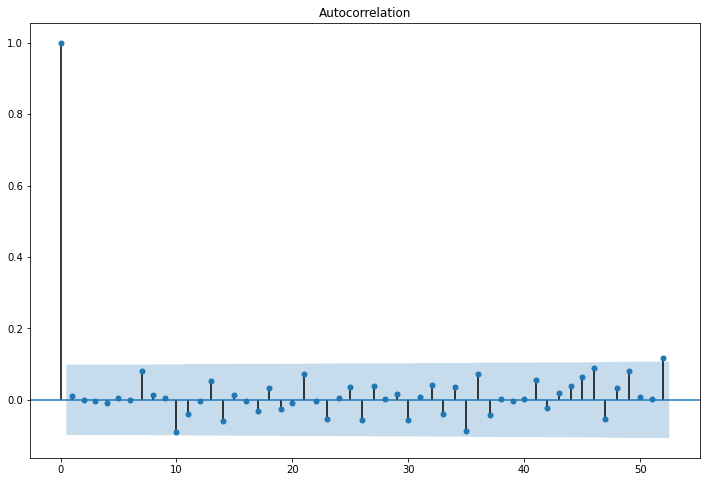

In [25]:
fig, ax = plt.subplots(figsize=(12, 8))
sm.graphics.tsa.plot_acf(results_ARIMA.resid, lags=52, ax=ax)
plt.show()

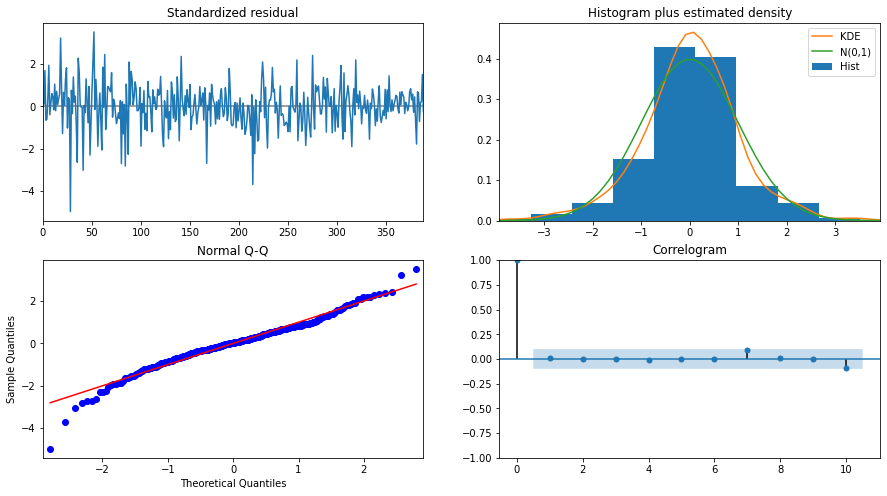

In [26]:
results_ARIMA.plot_diagnostics(figsize=(15, 8))
plt.show()

Показатели говорят о том, что остаток ряда достаточно хорошо похож на стационарный.

In [27]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true[y_true==0] = 1
    return np.mean(np.abs(y_true - y_pred) / np.abs(y_true)) * 100

In [28]:
y_pred_arima = results_ARIMA.forecast(h)   

In [29]:
er_arima = mean_absolute_percentage_error(data_w['first_diff'].values[-h:], y_pred_arima)

__Предсказание с помощью GradientBoostingRegressor__

In [30]:
X = data_w.iloc[:-h, :].values
y = data_w['first_diff'].values[h:]

In [31]:
X.shape[0], y.shape[0]

(396, 396)

In [32]:
model_gb = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)

In [33]:
model_gb.fit(X[:-h], y[:-h])
y_pred_gb = model_gb.predict(X[-h:])

In [40]:
er_gb = mean_absolute_percentage_error(y_true=data_w['first_diff'].values[-h:],y_pred=y_pred_gb)

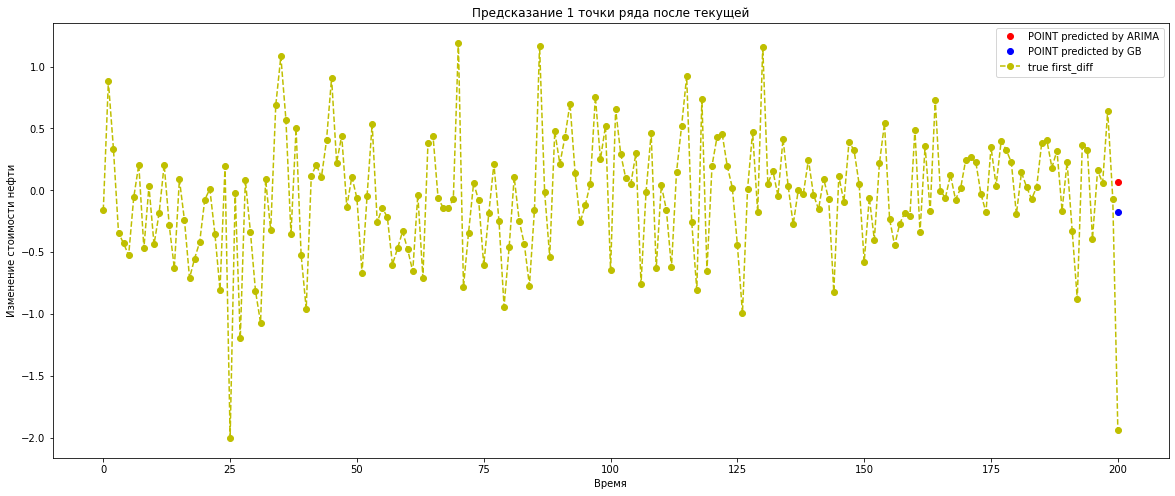

In [42]:
plt.figure(figsize=(20, 8)) 

N = 200
plt.plot(N, y_pred_arima, 'or', label='POINT predicted by ARIMA');
plt.plot(N, y_pred_gb, 'ob', label='POINT predicted by GB');

plt.plot(np.arange(N+1), data_w['first_diff'].values[-N-h:],'-oy', linestyle='dashed', label='true first_diff');

plt.title('Предсказание 1 точки ряда после текущей');
plt.xlabel('Время')
plt.ylabel('Изменение стоимости нефти')

plt.legend()
plt.show()

 -------------------------------------------------------------------------------------------------------------------------

5. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

In [41]:
print(f'MAPE ARIMA: {er_arima:.2f}%,\n'
      f'MAPE Gradient Boosting: {er_gb:.2f}%')

MAPE ARIMA: 103.34%,
MAPE Gradient Boosting: 90.96%


Предсказание на основе ARIMA оказалось хуже, чем предсказание на основе градиентного бустинга.   
Значение ошибки очень большое, что, по-моему, становится понятно из графика и объясняется резким скачком графика в точке 200 (подобный скачок был только в 25-ой точке). Предыдущие точки графика находятся гораздо ближе к предсказанным значениям.